In [1]:
import os
from tree_sitter_languages import get_parser
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
PARSERS = {
    ".py": "python",
    ".js": "javascript",
    ".mjs": "javascript", # mjs file extension stands for "module JavaScript."
    ".go": "go",
    ".bash": "bash",
    ".c": "c",
    ".cc": "cpp",
    ".cs": "c_sharp",
    ".cl": "commonlisp",
    ".cpp": "cpp",
    ".css": "css",
    ".dockerfile": "dockerfile",
    ".dot": "dot",
    ".el": "elisp",
    ".ex": "elixir",
    ".elm": "elm",
    ".et": "embedded_template",
    ".erl": "erlang",
    ".gomod": "gomod",
    ".hack": "hack",
    ".hs": "haskell",
    ".hcl": "hcl",
    ".html": "html",
    ".java": "java",
    ".jsdoc": "jsdoc",
    ".json": "json",
    ".jl": "julia",
    ".kt": "kotlin",
    ".lua": "lua",
    ".mk": "make",
    # ".md": "markdown", # https://github.com/ikatyang/tree-sitter-markdown/issues/59
    ".m": "objc",
    ".ml": "ocaml",
    ".pl": "perl",
    ".php": "php",
    ".ql": "ql",
    ".r": "r",
    ".R": "r",
    ".regex": "regex",
    ".rst": "rst",
    ".rb": "ruby",
    ".rs": "rust",
    ".scala": "scala",
    ".sql": "sql",
    ".sqlite": "sqlite",
    ".toml": "toml",
    ".tsq": "tsq",
    ".tsx": "typescript",
    ".ts": "typescript",
    ".yaml": "yaml",
}


def filename_to_lang(filename):
    file_extension = os.path.splitext(filename)[1]
    lang = PARSERS.get(file_extension)
    return lang


SCM_FILES = ['c_sharp', 'c', 'cpp', 'elisp', 'elixir', 'elm', 'go', 'java', 'javascript', 'ocaml', 'php', 'python', 'ql', 'ruby', 'rust', 'typescript']

In [3]:
def extract_methods_and_calls(code, lang):
    parser = get_parser(lang)

    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    methods = {}
    calls = {}

    def visit_node(node, current_method=None, current_code=None):
        if node.type in ['function_definition']:
            method_name_node = node.child_by_field_name('name')
            if method_name_node:
                current_method = method_name_node.text.decode('utf8')
                current_code = code[node.start_byte:node.end_byte]
                methods[current_method] = current_code
                calls[current_method] = []

        if node.type in ['call']:
            function_name_node = node.child_by_field_name('function')
            if function_name_node and current_method:
                callee = function_name_node.text.decode('utf8')
                calls[current_method].append(callee)

        for child in node.children:
            visit_node(child, current_method, current_code)

    visit_node(root_node)
    return calls, methods

In [4]:
def read_repository(dir_path):
    method_call_dict = {}
    method_code_dict = {}

    for file_dir in os.listdir(dir_path):
        new_dir = os.path.join(dir_path, file_dir)
        if os.path.isdir(new_dir):
            new_method_call_dict, new_method_code_dict = read_repository(new_dir)
            method_call_dict.update(new_method_call_dict)
            method_code_dict.update(new_method_code_dict)
        if os.path.isfile(new_dir):
            lang = filename_to_lang(file_dir)
            if lang is None:
                continue
            if lang not in SCM_FILES:
                continue
            with open(new_dir, 'r') as f:
                try:
                    code = f.read()
                except:
                    print(f"file: {file_dir} located at {new_dir} could not be read")
                    continue
                else:
                    new_method_call_dict, new_method_code_dict = extract_methods_and_calls(code, lang)
                    method_call_dict.update(new_method_call_dict)
                    method_code_dict.update(new_method_code_dict)
                # break

    return method_call_dict, method_code_dict

In [5]:
def create_method_graph(method_call_dict):
    G = nx.DiGraph()
    for method in method_call_dict:
        for method_called in method_call_dict[method]:
            G.add_edge(method, method_called)

    return G

In [6]:
repo_file_path = "/home/jatinkulkarni/final_project"

method_call_dict, method_code_dict= read_repository(repo_file_path)

graph = create_method_graph(method_call_dict)

/home/jatinkulkarni/miniconda3/envs/repo_structure_env/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


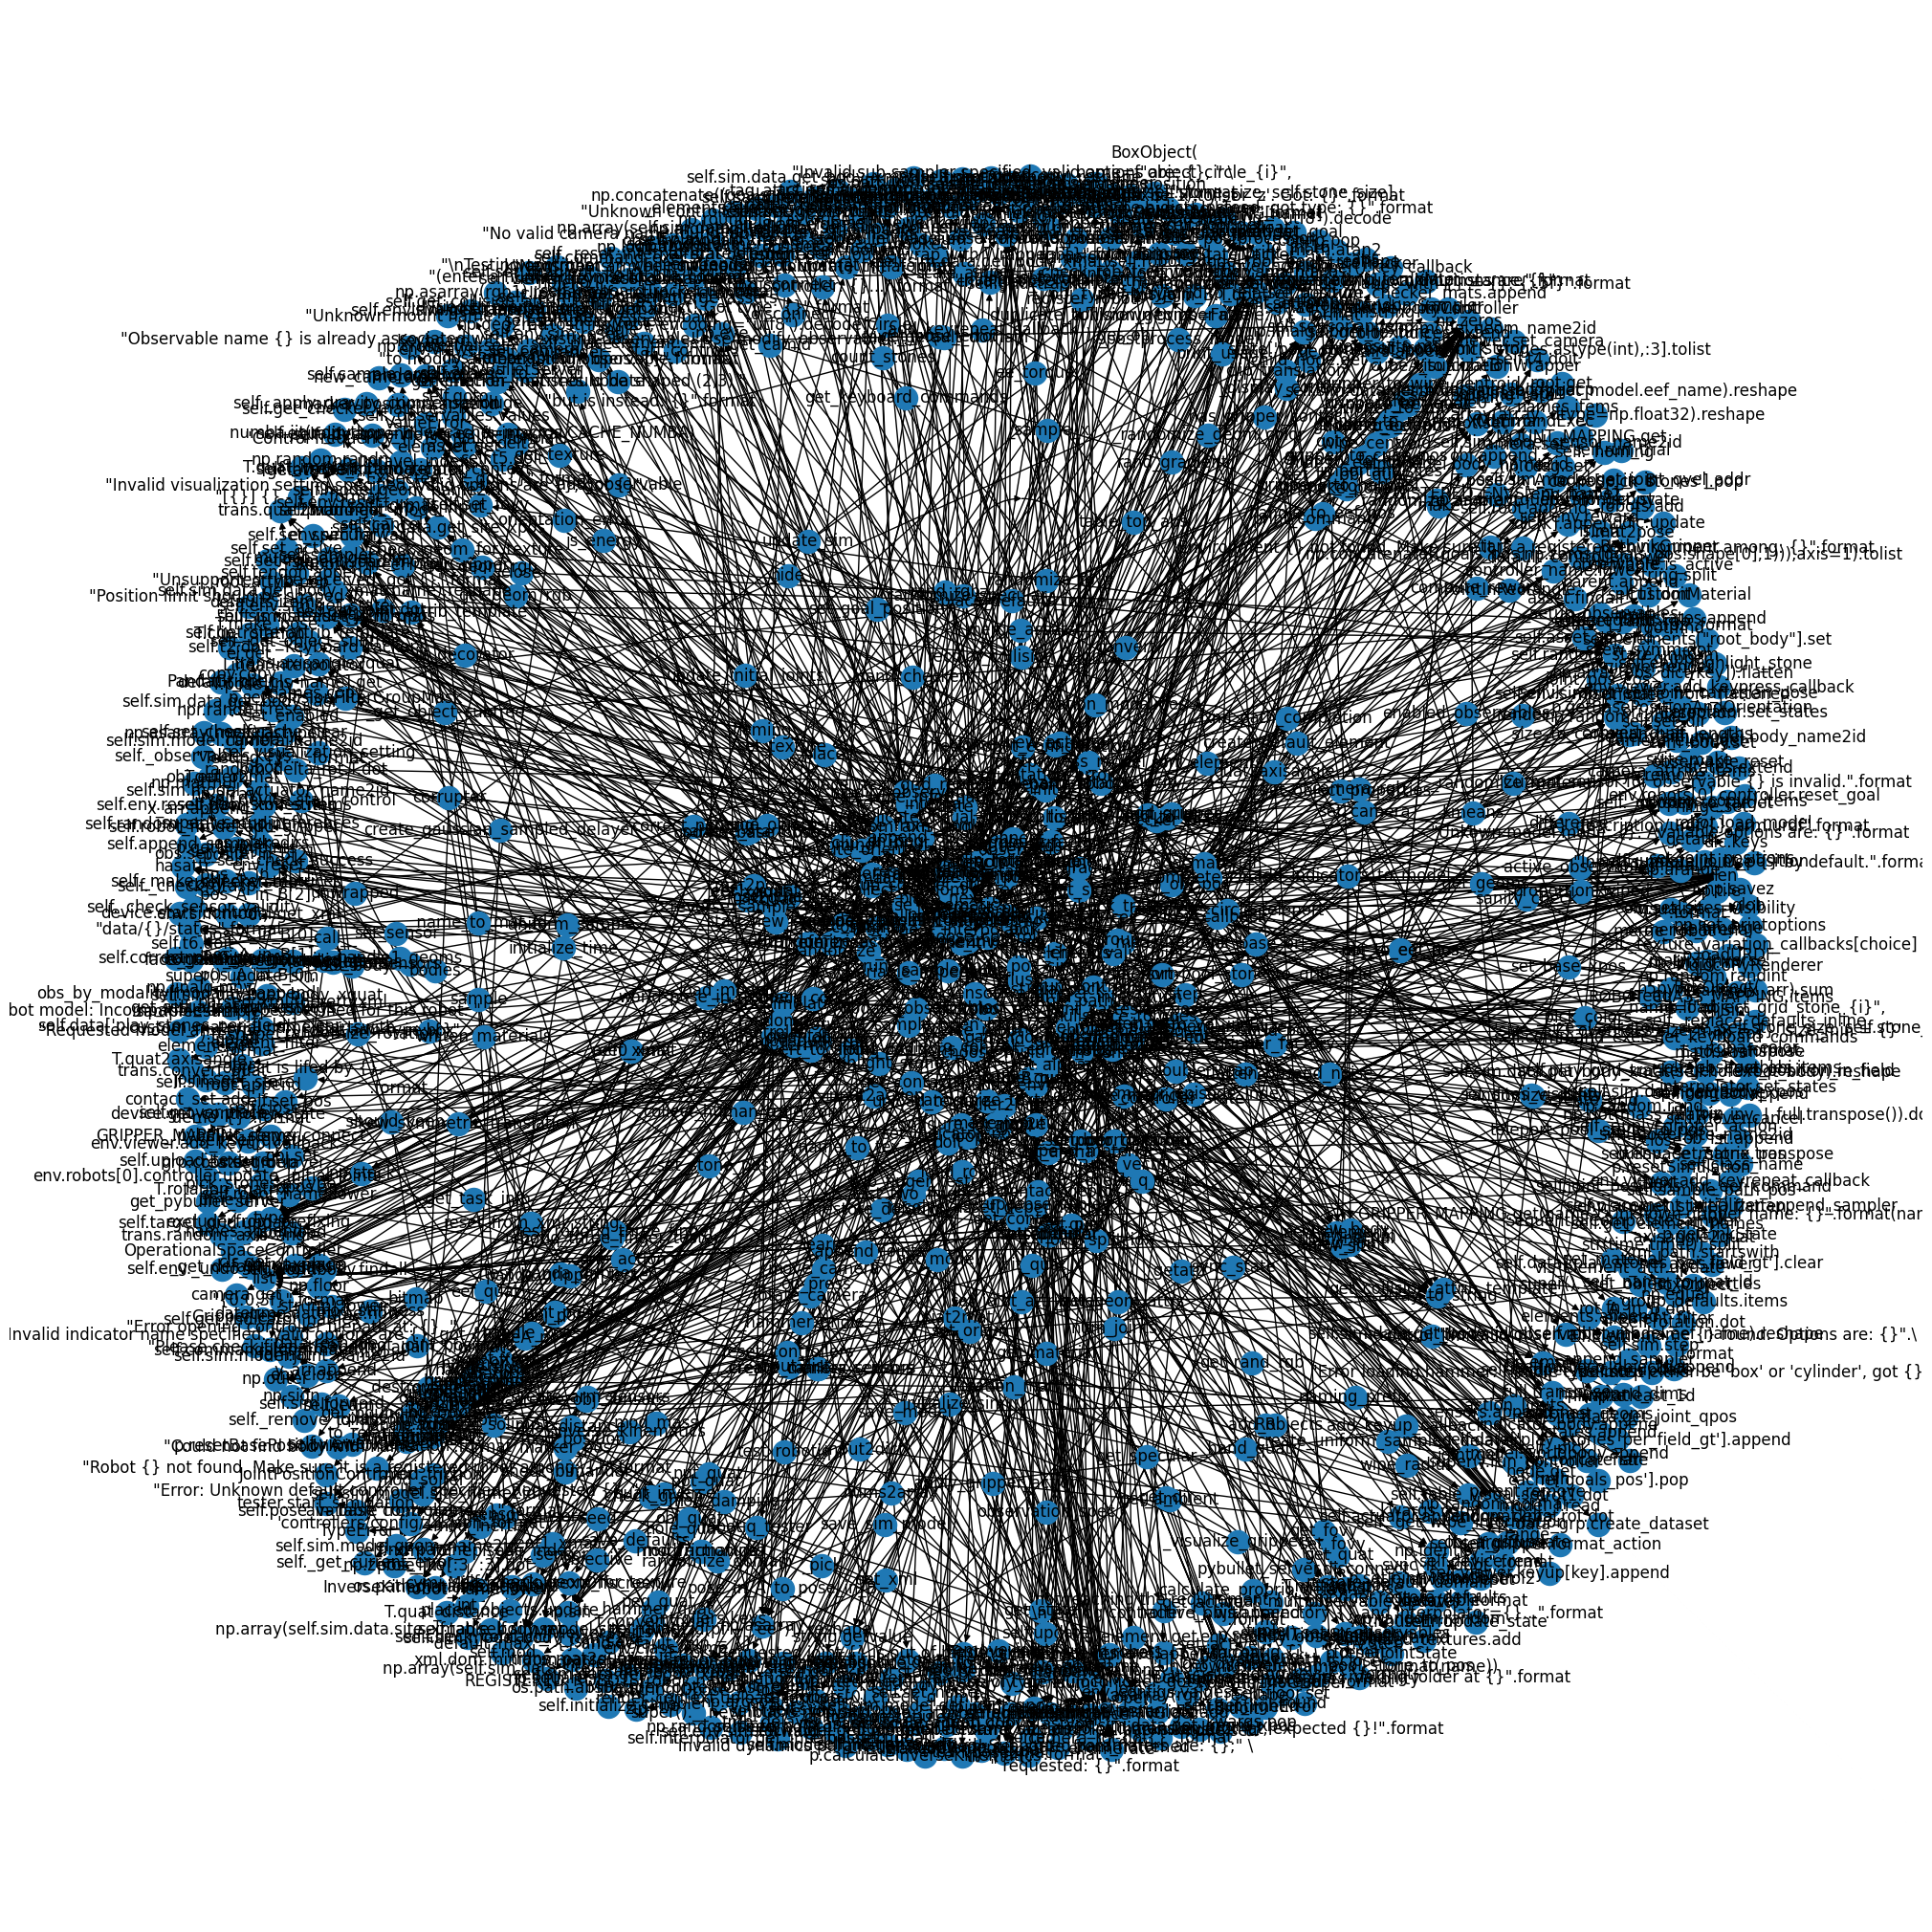

In [7]:
plt.figure(figsize=(20, 20))
nx.draw(graph, with_labels=True)
plt.savefig('method_graph.png')
plt.show()